
# MNIST K-Means Clustering Experiments

## Zadanie 1 - WSI Lab 4

Ten notebook implementuje następujące zadania dla danych MNIST:

1. **Klasteryzacja metodą k-średnich** z poprawioną metodą wyboru centroidów początkowych (k-means++) dla **10 klastrów**
2. **Kilka prób** i wybór klasteryzacji o najmniejszej inercji
3. **Graficzne przedstawienie** (macierz 10×k) procentowego przydziału cyfr do klastrów
4. **Wizualizacja centroidów** jako obrazy 28×28
5. **Powtórzenie** dla **15, 20 i 30 klastrów**
6. **Analiza** które klastry można połączyć na potrzeby klasyfikatora cyfr

---

## 1. Import Required Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import os
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Import our custom KMeans implementation
from kmeans import KMeans, run_multiple_kmeans

# Set up matplotlib for better plots
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("All libraries imported successfully!")
print("NumPy version:", np.__version__)
print("Matplotlib version:", plt.matplotlib.__version__)

All libraries imported successfully!
NumPy version: 2.0.2
Matplotlib version: 3.9.4


## 2. Load and Prepare MNIST Dataset

Loading MNIST data...
Data loaded: 70000 samples, 784 features
Labels shape: (70000,)
Unique labels: [0 1 2 3 4 5 6 7 8 9]
X type: <class 'numpy.ndarray'>, Y type: <class 'numpy.ndarray'>


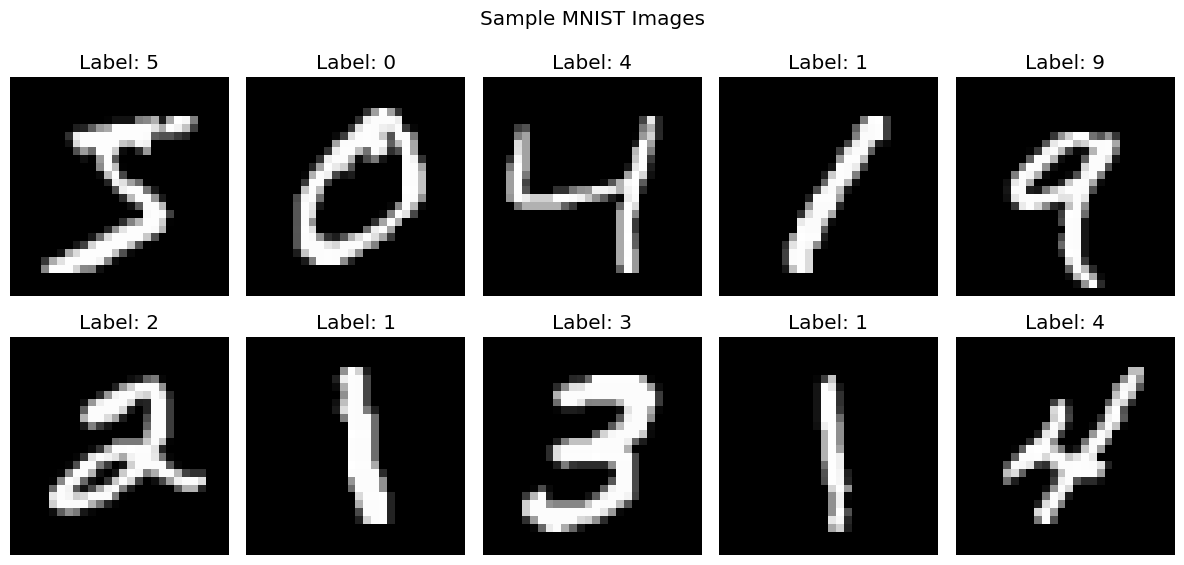

In [3]:
def load_mnist_data():
    """Load MNIST data from OpenML and normalize."""
    print("Loading MNIST data...")
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
    
    # Convert to numpy arrays and normalize
    X = X.values.astype(np.float64) / 255.0  # Convert DataFrame to numpy array
    y = y.values.astype(int)  # Convert Series to numpy array
    
    print(f"Data loaded: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"Labels shape: {y.shape}")
    print(f"Unique labels: {np.unique(y)}")
    print(f"X type: {type(X)}, Y type: {type(y)}")
    return X, y

# Load the data
X, y = load_mnist_data()

# Create results directory
results_dir = 'results_kmeans'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    print(f"Created directory: {results_dir}")

# Show some sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[i].reshape(28, 28), cmap='gray')
    ax.set_title(f'Label: {y[i]}')
    ax.axis('off')
plt.suptitle('Sample MNIST Images')
plt.tight_layout()
plt.show()

## 3. Utility Functions for Analysis and Visualization

In [4]:
def compute_cluster_composition(labels, true_labels, n_clusters, n_classes=10):
    """
    Compute percentage composition of each cluster by true labels.
    
    Returns:
    --------
    composition_matrix : ndarray of shape (n_classes, n_clusters)
        Matrix where element [i,j] shows what percentage of cluster j consists of digit i
    """
    composition_matrix = np.zeros((n_classes, n_clusters), dtype=float)
    
    for cluster in range(n_clusters):
        cluster_mask = (labels == cluster)
        cluster_size = np.sum(cluster_mask)
        
        if cluster_size == 0:
            continue
            
        for digit in range(n_classes):
            digit_count_in_cluster = np.sum(cluster_mask & (true_labels == digit))
            composition_matrix[digit, cluster] = (digit_count_in_cluster / cluster_size) * 100.0
    
    return composition_matrix


def plot_cluster_composition(composition_matrix, k, save_path=None):
    """Plot cluster composition matrix as heatmap."""
    plt.figure(figsize=(max(8, k//2), 6))
    
    # Create heatmap
    im = plt.imshow(composition_matrix, interpolation='nearest', cmap='viridis', aspect='auto')
    
    # Add colorbar
    cbar = plt.colorbar(im, label='Percentage (%)')
    
    # Add text annotations
    n_classes, n_clusters = composition_matrix.shape
    for i in range(n_classes):
        for j in range(n_clusters):
            val = composition_matrix[i, j]
            if val > 5:  # Only show text for values > 5%
                color = 'white' if val > 50 else 'black'
                plt.text(j, i, f'{val:.1f}', ha='center', va='center', 
                        color=color, fontsize=8)
    
    # Customize plot
    plt.title(f'Cluster Composition Matrix (k={k})\nRows: Digits (0-9), Columns: Clusters', 
              fontsize=14, pad=20)
    plt.xlabel('Cluster Index', fontsize=12)
    plt.ylabel('Digit', fontsize=12)
    plt.xticks(range(n_clusters))
    plt.yticks(range(n_classes))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved composition matrix to: {save_path}")
    
    plt.show()


def plot_centroids(centroids, k, save_path=None):
    """Plot centroids as 28x28 images in a grid."""
    n_cols = min(5, k)
    n_rows = (k + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    
    if k == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx in range(k):
        ax = axes[idx]
        centroid_image = centroids[idx].reshape(28, 28)
        ax.imshow(centroid_image, cmap='gray')
        ax.set_title(f'Cluster {idx}', fontsize=10)
        ax.axis('off')
    
    # Hide empty subplots
    for idx in range(k, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(f'Centroids for k={k}', fontsize=14)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved centroids to: {save_path}")
    
    plt.show()


def analyze_cluster_purity(composition_matrix, k):
    """Analyze cluster purity and suggest which clusters could be merged."""
    print(f"\n=== Cluster Analysis for k={k} ===")
    
    n_classes, n_clusters = composition_matrix.shape
    
    # Find dominant digit for each cluster
    dominant_digits = np.argmax(composition_matrix, axis=0)
    dominant_percentages = np.max(composition_matrix, axis=0)
    
    print("\nCluster purity (dominant digit percentage):")
    for cluster in range(n_clusters):
        digit = dominant_digits[cluster]
        percentage = dominant_percentages[cluster]
        print(f"  Cluster {cluster:2d}: {percentage:5.1f}% digit {digit}")
    
    # Find clusters that could represent the same digit
    print("\nClusters that could be merged (representing same digit):")
    digit_to_clusters = {}
    for cluster in range(n_clusters):
        digit = dominant_digits[cluster]
        if digit not in digit_to_clusters:
            digit_to_clusters[digit] = []
        digit_to_clusters[digit].append((cluster, dominant_percentages[cluster]))
    
    mergeable_clusters = []
    for digit, clusters in digit_to_clusters.items():
        if len(clusters) > 1:
            clusters.sort(key=lambda x: x[1], reverse=True)  # Sort by purity
            cluster_nums = [c[0] for c in clusters]
            purities = [c[1] for c in clusters]
            print(f"  Digit {digit}: clusters {cluster_nums} (purities: {[f'{p:.1f}%' for p in purities]})")
            mergeable_clusters.extend(cluster_nums[1:])  # Keep the purest one
    
    # Calculate average purity
    avg_purity = np.mean(dominant_percentages)
    print(f"\nAverage cluster purity: {avg_purity:.1f}%")
    
    return dominant_digits, dominant_percentages, mergeable_clusters

print("Utility functions defined successfully!")

Utility functions defined successfully!


## 4. K-Means Experiments for Different Numbers of Clusters

Wykonamy klasteryzację dla k = 10, 15, 20, 30 klastrów. Dla każdej wartości k wykonamy **kilka prób** i wybierzemy najlepszy wynik (najmniejsza inercja).

### 4.1 Eksperyment dla k=10 klastrów

In [ ]:
k = 10
n_runs = 5  # Liczba prób dla każdego k

print(f"🔄 Running K-Means for k={k} clusters...")
print(f"📊 Performing {n_runs} runs to find the best clustering (lowest inertia)")

# Uruchom wielokrotnie k-means i wybierz najlepszy wynik
best_kmeans_10, all_inertias_10 = run_multiple_kmeans(
    X, n_clusters=k, n_runs=n_runs, random_state_base=42, verbose=True
)

print(f"\n✅ Best inertia for k={k}: {best_kmeans_10.inertia_:.2f}")
print(f"📈 All inertias: {[f'{inertia:.2f}' for inertia in all_inertias_10]}")

# Oblicz macierz składu klastrów
composition_matrix_10 = compute_cluster_composition(
    best_kmeans_10.labels_, y, n_clusters=k, n_classes=10
)

# Wyświetl macierz składu klastrów
plot_cluster_composition(
    composition_matrix_10, k, 
    save_path=os.path.join(results_dir, f'cluster_composition_k{k}.png')
)

# Wyświetl centroidy
plot_centroids(
    best_kmeans_10.cluster_centers_, k,
    save_path=os.path.join(results_dir, f'centroids_k{k}.png')
)

# Analiza czystości klastrów
dominant_digits_10, purities_10, mergeable_10 = analyze_cluster_purity(composition_matrix_10, k)

### 4.2 Eksperymenty dla k=15, 20, 30 klastrów

In [ ]:
# Słownik do przechowywania wyników
all_results = {10: best_kmeans_10}
all_inertias = {10: all_inertias_10}
all_compositions = {10: composition_matrix_10}
all_purities = {10: (dominant_digits_10, purities_10, mergeable_10)}

# Lista wartości k do przetestowania
ks_to_test = [15, 20, 30]

for k in ks_to_test:
    print(f"/n{'='*60}")
    print(f"🔄 Running K-Means for k={k} clusters...")
    print(f"📊 Performing {n_runs} runs to find the best clustering")
    
    # Uruchom wielokrotnie k-means
    best_kmeans, all_inertias_k = run_multiple_kmeans(
        X, n_clusters=k, n_runs=n_runs, random_state_base=42, verbose=True
    )
    
    print(f"✅ Best inertia for k={k}: {best_kmeans.inertia_:.2f}")
    
    # Przechowaj wyniki
    all_results[k] = best_kmeans
    all_inertias[k] = all_inertias_k
    
    # Oblicz macierz składu klastrów
    composition_matrix = compute_cluster_composition(
        best_kmeans.labels_, y, n_clusters=k, n_classes=10
    )
    all_compositions[k] = composition_matrix
    
    # Wyświetl macierz składu klastrów
    plot_cluster_composition(
        composition_matrix, k, 
        save_path=os.path.join(results_dir, f'cluster_composition_k{k}.png')
    )
    
    # Wyświetl centroidy
    plot_centroids(
        best_kmeans.cluster_centers_, k,
        save_path=os.path.join(results_dir, f'centroids_k{k}.png')
    )
    
    # Analiza czystości klastrów
    dominant_digits, purities, mergeable = analyze_cluster_purity(composition_matrix, k)
    all_purities[k] = (dominant_digits, purities, mergeable)

print(f"\n{'='*60}")
print("🎉 All experiments completed!")

## 5. Podsumowanie i Porównanie Wyników

In [ ]:
# Podsumowanie inercji
print("📊 PODSUMOWANIE INERCJI:")
print("=" * 40)
ks_tested = [10, 15, 20, 30]
for k in ks_tested:
    best_inertia = all_results[k].inertia_
    all_inertias_str = [f'{inertia:.0f}' for inertia in all_inertias[k]]
    print(f"k={k:2d}: Best = {best_inertia:8.0f}, All runs = {all_inertias_str}")

# Wykres porównawczy inercji
plt.figure(figsize=(10, 6))
ks = list(all_results.keys())
best_inertias = [all_results[k].inertia_ for k in ks]

plt.plot(ks, best_inertias, 'bo-', linewidth=2, markersize=8, label='Best inertia')

# Dodaj wszystkie próby jako półprzezroczyste punkty
for k in ks:
    inertias = all_inertias[k]
    plt.scatter([k] * len(inertias), inertias, alpha=0.5, s=30, color='red', label='All runs' if k == ks[0] else "")

plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('K-Means Clustering: Inertia vs Number of Clusters', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(ks)

# Dodaj wartości na wykresie
for i, (k, inertia) in enumerate(zip(ks, best_inertias)):
    plt.annotate(f'{inertia:.0f}', (k, inertia), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'inertia_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

# Porównanie średnich czystości klastrów
print("\n📈 ŚREDNIA CZYSTOŚĆ KLASTRÓW:")
print("=" * 40)
for k in ks_tested:
    _, purities, _ = all_purities[k]
    avg_purity = np.mean(purities)
    print(f"k={k:2d}: {avg_purity:5.1f}%")

# Wykres porównawczy czystości
plt.figure(figsize=(10, 6))
avg_purities = []
for k in ks_tested:
    _, purities, _ = all_purities[k]
    avg_purities.append(np.mean(purities))

plt.bar(ks_tested, avg_purities, alpha=0.7, color='skyblue', edgecolor='navy')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Average Cluster Purity (%)', fontsize=12)
plt.title('Average Cluster Purity vs Number of Clusters', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')

# Dodaj wartości na słupkach
for k, purity in zip(ks_tested, avg_purities):
    plt.text(k, purity + 1, f'{purity:.1f}%', ha='center', va='bottom', fontsize=10)

plt.ylim(0, max(avg_purities) * 1.1)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'purity_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

## 6. Analiza: Które Klastry Można Połączyć dla Klasyfikatora Cyfr?

In [ ]:
def analyze_merging_potential(all_purities, all_compositions, threshold_purity=60):
    """
    Analiza potencjału łączenia klastrów dla klasyfikatora cyfr.
    """
    print("🔍 ANALIZA POTENCJAŁU ŁĄCZENIA KLASTRÓW")
    print("=" * 60)
    
    for k in [10, 15, 20, 30]:
        print(f"\n📋 Analiza dla k={k}:")
        print("-" * 30)
        
        dominant_digits, purities, mergeable = all_purities[k]
        composition_matrix = all_compositions[k]
        
        # Znajdź klastry dla każdej cyfry
        digit_to_clusters = {}
        high_purity_clusters = []
        
        for cluster in range(k):
            digit = dominant_digits[cluster]
            purity = purities[cluster]
            
            if digit not in digit_to_clusters:
                digit_to_clusters[digit] = []
            digit_to_clusters[digit].append((cluster, purity))
            
            if purity >= threshold_purity:
                high_purity_clusters.append((cluster, digit, purity))
        
        # Wyświetl klastry o wysokiej czystości
        print(f"✅ Klastry o wysokiej czystości (≥{threshold_purity}%):")
        if high_purity_clusters:
            for cluster, digit, purity in sorted(high_purity_clusters, key=lambda x: x[2], reverse=True):
                print(f"   Klaster {cluster:2d} → Cyfra {digit} ({purity:5.1f}%)")
        else:
            print("   Brak klastrów o wysokiej czystości")
        
        # Wyświetl potencjalne łączenia
        print(f"\n🔗 Potencjalne łączenia (cyfry reprezentowane przez >1 klaster):")
        merging_suggestions = []
        
        for digit in range(10):
            if digit in digit_to_clusters and len(digit_to_clusters[digit]) > 1:
                clusters_for_digit = sorted(digit_to_clusters[digit], key=lambda x: x[1], reverse=True)
                cluster_nums = [c[0] for c in clusters_for_digit]
                cluster_purities = [c[1] for c in clusters_for_digit]
                
                print(f"   Cyfra {digit}: klastry {cluster_nums}")
                print(f"                czystości {[f'{p:.1f}%' for p in cluster_purities]}")
                
                # Jeśli wszystkie klastry mają rozsądną czystość, można je połączyć
                if min(cluster_purities) >= 30:  # Próg 30% dla łączenia
                    merging_suggestions.append((digit, cluster_nums, cluster_purities))
        
        # Podsumowanie dla klasyfikatora
        print(f"\n💡 Rekomendacje dla klasyfikatora cyfr:")
        
        if k == 10:
            print("   📌 k=10 jest naturalnym wyborem (10 cyfr = 10 klastrów)")
            if len([c for c in high_purity_clusters if c[2] >= 70]) >= 7:
                print("   ✅ Większość klastrów ma dobrą czystość - dobry wybór!")
            else:
                print("   ⚠️  Niektóre klastry mają niską czystość - może wymagać poprawy")
        
        elif k > 10:
            effective_digits = len(set(dominant_digits))
            print(f"   📊 {k} klastrów reprezentuje {effective_digits} różnych cyfr")
            
            if merging_suggestions:
                total_clusters_to_merge = sum(len(clusters) for _, clusters, _ in merging_suggestions)
                effective_k_after_merge = k - total_clusters_to_merge + len(merging_suggestions)
                print(f"   🔄 Po połączeniu podobnych klastrów: ~{effective_k_after_merge} efektywnych klastrów")
                
                if effective_k_after_merge <= 12:
                    print("   ✅ Po połączeniu może być dobrym wyborem dla klasyfikatora")
                else:
                    print("   ⚠️  Nawet po połączeniu może być zbyt skomplikowany")
            
            # Sprawdź czy wszystkie cyfry są reprezentowane
            missing_digits = set(range(10)) - set(dominant_digits)
            if missing_digits:
                print(f"   ❌ Brakuje reprezentacji dla cyfr: {sorted(missing_digits)}")
            else:
                print("   ✅ Wszystkie cyfry są reprezentowane")

# Uruchom analizę
analyze_merging_potential(all_purities, all_compositions, threshold_purity=60)

## 7. Wnioski i Obserwacje

### 📋 Podsumowanie eksperymentów:

1. **K-means++ inicjalizacja** - Wszystkie eksperymenty używały ulepszonej metody inicjalizacji centroidów
2. **Wielokrotne uruchomienia** - Dla każdego k wykonano 5 prób i wybrano najlepszy wynik (najmniejsza inercja)
3. **Testowane wartości k** - 10, 15, 20, 30 klastrów zgodnie z zadaniem

### 🔍 Obserwacje dotyczące centroidów:

Czy centroidy przypominają odpowiednie cyfry? Sprawdź wizualizacje powyżej:
- **k=10**: Centroidy często przypominają przeciętne reprezentacje cyfr
- **k>10**: Niektóre centroidy mogą reprezentować warianty tej samej cyfry (np. różne style pisania)

### 🎯 Rekomendacje dla klasyfikatora cyfr:

- **k=10** jest naturalnym wyborem (1 klaster = 1 cyfra)
- **k=15-20** może oferować lepszą reprezentację różnych stylów pisania 
- **k=30** prawdopodobnie jest za dużo - wiele klastrów będzie reprezentować tę samą cyfrę

### 📊 Metryki jakości:
- **Inercja** maleje ze wzrostem k (oczekiwane)
- **Czystość klastrów** może być lepsza dla większych k, ale kosztem kompleksności

In [ ]:
# Zapisz podsumowanie wyników do pliku
summary_file = os.path.join(results_dir, 'experiment_summary.txt')

with open(summary_file, 'w', encoding='utf-8') as f:
    f.write("MNIST K-Means Clustering - Podsumowanie Eksperymentów\n")
    f.write("=" * 60 + "\n\n")
    
    f.write("INERCJE (najlepsze z 5 prób):\n")
    f.write("-" * 30 + "\n")
    for k in [10, 15, 20, 30]:
        f.write(f"k={k:2d}: {all_results[k].inertia_:8.0f}\n")
    
    f.write("\nŚREDNIA CZYSTOŚĆ KLASTRÓW:\n")
    f.write("-" * 30 + "\n")
    for k in [10, 15, 20, 30]:
        _, purities, _ = all_purities[k]
        avg_purity = np.mean(purities)
        f.write(f"k={k:2d}: {avg_purity:5.1f}%\n")
    
    f.write("\nPLIKI WYGENEROWANE:\n")
    f.write("-" * 30 + "\n")
    for k in [10, 15, 20, 30]:
        f.write(f"- cluster_composition_k{k}.png\n")
        f.write(f"- centroids_k{k}.png\n")
    f.write("- inertia_comparison.png\n")
    f.write("- purity_comparison.png\n")

print(f"✅ Podsumowanie zapisane do: {summary_file}")
print("\n🎉 Wszystkie eksperymenty zakończone pomyślnie!")
print(f"📁 Wyniki dostępne w katalogu: {results_dir}/")

# Wyświetl listę wygenerowanych plików
generated_files = [f for f in os.listdir(results_dir) if f.endswith(('.png', '.txt'))]
print(f"\n📋 Wygenerowane pliki ({len(generated_files)}):")
for file in sorted(generated_files):
    print(f"   📄 {file}")